In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr

from plot_utils import plot_ground_truth_heatmap, plot_spike_grps

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

from sim_utils import load_regime_results, launch_regime_feat_sel, create_trial_jobs
from sim_utils import get_sim_params, get_sim_params
from sim_utils import generate_x_mtx, generate_spike_mtx
from plot_utils import plot_ground_truth_heatmap
from plot_utils import check_spike_groups, check_example_noise_matrix
def visualize_setup(sim_id, plot_mtx=False):
    check_spike_groups(sim_id)
    if plot_mtx:
        check_example_noise_matrix(sim_id, 0.2)

In [3]:
sim_id = "main_sim_6"
sim_params = get_sim_params(sim_id)
sim_params

{'seed': 1,
 'n_samps': 1500,
 'z_param': {'spike_grp': ['left', 'right'],
  'n_repetitions': 1,
  'rel_noise_list': [1, 0.1]},
 'x_param': {'spike_grp': ['right',
   'left',
   'mid',
   'mid_r',
   'multi_left',
   'multi_right'],
  'n_repetitions': None,
  'rel_noise_list': None,
  'seed_offset': 0},
 'n_trials': 100,
 'noise_levs': [0.1, 0.5, 1, 1.5, 2, 3],
 'sparsities': [0.05, 0.1, 0.2],
 'target_vars': 9000,
 'methods': ['unsup_pc', 'unsup_graph', 'pc', 'graph'],
 'graph_k': 10,
 'n_perms': 10000,
 'alpha': 0.05,
 'perm_method': 'pool',
 'sim_dir': '/share/PI/sabatti/feat_viz/main_sim_6',
 'save': True,
 'check_skip': False,
 'null_struct': {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}}

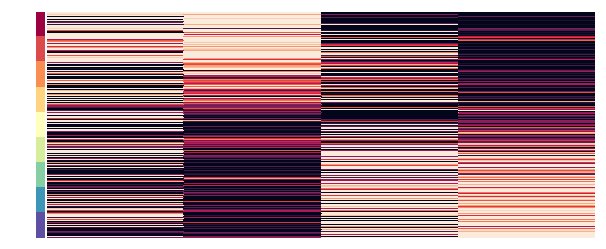

[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


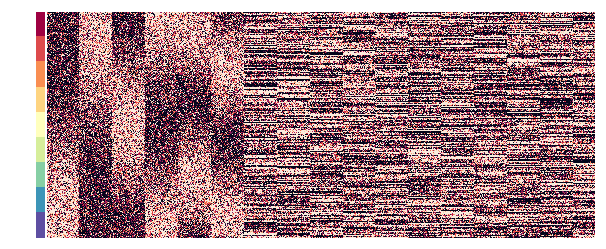

In [4]:
np.random.seed(sim_params["seed"])
lam_true = np.random.uniform(size=sim_params["n_samps"])
z, _ = generate_spike_mtx(lam_true, **sim_params["z_param"])
plot_ground_truth_heatmap(lam_true, z)

x_param = sim_params["x_param"]
x_param["rel_noise_list"] = [0.5]
x_param["n_repetitions"] = 150
x = generate_x_mtx(lam_true, x_param, sim_params)
plot_ground_truth_heatmap(lam_true, x[:,:2500])

In [5]:
# TODO:
# 1. run g-aloe on this to make sure the correct variables are selected
# 2. fit splines on the selected variables (using spline fit) -> feat_viz
# 3. collect the parameter matrix -> feat_viz
from main_methods import run_procedure, run_unsupervised, evaluate_result
from general_utils import evaluate_rejections

meth_params = {
    "method": "graph",
    "n_perms": 10000,
    "perm_method": "pool",
    "alpha": 0.05, 
    "graph_k": 10,
}
result = run_procedure(z, x, meth_params)
result.keys()
n_proto = len(x_param["spike_grp"])
n_rep = x_param["n_repetitions"]
nn_idx = np.arange(n_rep*n_proto)
rej_idx = result["rejections"]
mt_res = evaluate_rejections(set(rej_idx), set(nn_idx))
mt_res["Corr"] = abs(spearmanr(result["lam_update"], lam_true).correlation) 
mt_res

[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...


{'FDP': 0.02617801047120419,
 'Power': 0.8266666666666667,
 'Corr': 0.9957166167629409}

## TODO: use gap statistic and k-means/ spectral clustering to identify the clusters

In [6]:
# fit the spline with updated lambda and the x features
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin
zone_true = rank_and_bin(lam_true, n_bins=9)
lam = result["lam_update"]
var_ids = np.ones(x.shape[1]) * -1
for i in range(n_proto):
    var_ids[i*(n_rep): (i+1)*n_rep] = i
base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, x, base_args)

cr(x, knots=(-0.013, 0.013))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters


In [7]:
import umap
from plot_utils import plot_scatter_discrete
def compute_embedding(mtx, var_names, sel_idx=None):
    assert mtx.shape[0] == len(var_names), "dim mismatch"
    uobj = umap.UMAP(random_state=10101)
    if sel_idx is None:
        sel_idx = np.arange(len(var_names))
    logger.info("input dimension: {}".format(mtx[sel_idx, :].shape))
    embedding = uobj.fit_transform(mtx[sel_idx, :])
    df = pd.DataFrame(embedding, columns=["umap 1", "umap 2"])
    df["id"] = sel_idx
    df["var"] = var_names[sel_idx]
    return df

embed_dict = {}
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
for sel in sel_list:
    if sel == "rejected":
        sel_idx = rej_idx
    else:
        sel_idx = None
    for mat in mat_list:
        if mat == "coeffient":
            mtx = c_mtx
        else:
            mtx = x.T
        key = "{}_{}".format(sel, mat)
        logger.info("Computing embedding for: {}".format(key))
        df = compute_embedding(mtx, var_ids, sel_idx=sel_idx)
        embed_dict[key] = df

[feat_viz INFO] Computing embedding for: all_coeffient
[feat_viz INFO] input dimension: (9000, 5)
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components
[feat_viz INFO] Computing embedding for: all_expression
[feat_viz INFO] input dimension: (9000, 1500)
[feat_viz INFO] Computing embedding for: rejected_coeffient
[feat_viz INFO] input dimension: (764, 5)
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components
[feat_viz INFO] Computing embedding for: rejected_expression
[feat_viz INFO] input dimension: (764, 1500)


[feat_viz INFO] Counter({-1.0: 8100, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({-1.0: 8100, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({0.0: 150, 1.0: 150, 2.0: 147, 3.0: 144, 5.0: 78, 4.0: 75, -1.0: 20})
[feat_viz INFO] Counter({0.0: 150, 1.0: 150, 2.0: 147, 3.0: 144, 5.0: 78, 4.0: 75, -1.0: 20})


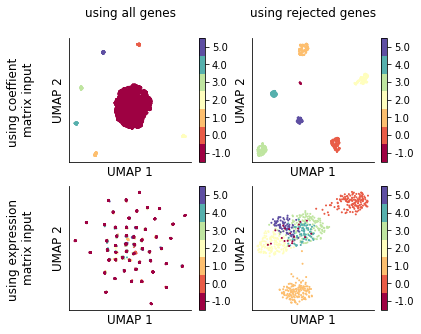

In [79]:
from collections import Counter
fontsize = 12
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        var_labs = plt_df["var"]
        logger.info("{}".format(Counter(var_labs)))
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
plt.show()

[feat_viz INFO] Fitted points stored in (50, 764)


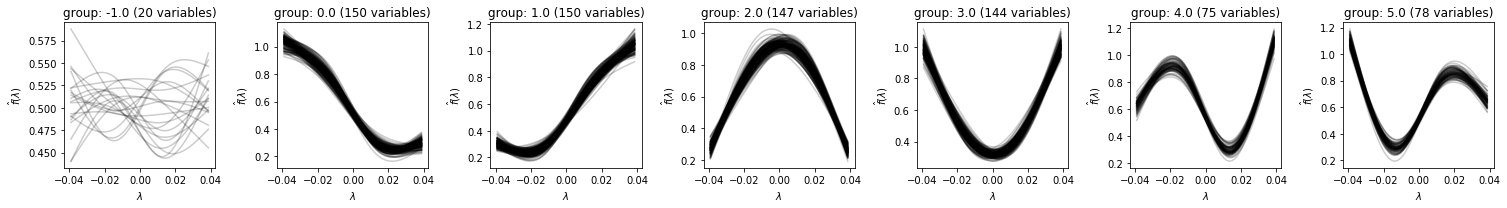

In [57]:
# partition the variables into groups
from patsy import dmatrix
clust_labs = var_ids
coeff_mtx = c_mtx 
# x = result["lam_update"]

def plot_multi_curves(ax, x, y_mtx, **kwargs):
    assert len(x) == y_mtx.shape[0], "dimension mismatch"
    for i in range(y_mtx.shape[1]):
        ax.plot(x, y_mtx[:,i], **kwargs)

def refit_curves(coeff_mtx, base_args, x):
    x = np.linspace(min(x), max(x), 50)
    exog = dmatrix(base_args, {"x": x}, return_type='dataframe')
    y = np.matmul(exog.values, coeff_mtx.T)
    logger.info("Fitted points stored in {}".format(y.shape))
    return x, y

def plot_group_curves(coeff_mtx, clust_labs, base_args, x_init):
    x_vals, fit_mtx = refit_curves(coeff_mtx, base_args, x_init)
    assert coeff_mtx.shape[0] == len(clust_labs), "dimension mismatch"
    unique_labs = np.unique(clust_labs)

    # compute the fitted curves for all genes on the right space
    fig, axes = plt.subplots(1, len(unique_labs), figsize=(3*len(unique_labs),3))
    for i_ax, i_lab in enumerate(unique_labs):
        ax = axes[i_ax]
        sel_var_idx = [i for i, lab in enumerate(clust_labs) if lab == i_lab]

        plot_multi_curves(ax, x_vals, fit_mtx[:, sel_var_idx], 
                          alpha=0.2, color="black")
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(r"$\hat{f}(\lambda)$")
        ax.set_title(r"group: {} ({} variables)".format(i_lab, len(sel_var_idx)))
    plt.tight_layout()
    plt.show()
    
plot_group_curves(c_mtx[rej_idx, :], var_ids[rej_idx], base_args, result["lam_update"])


[feat_viz INFO] Fitted points stored in (50, 9000)


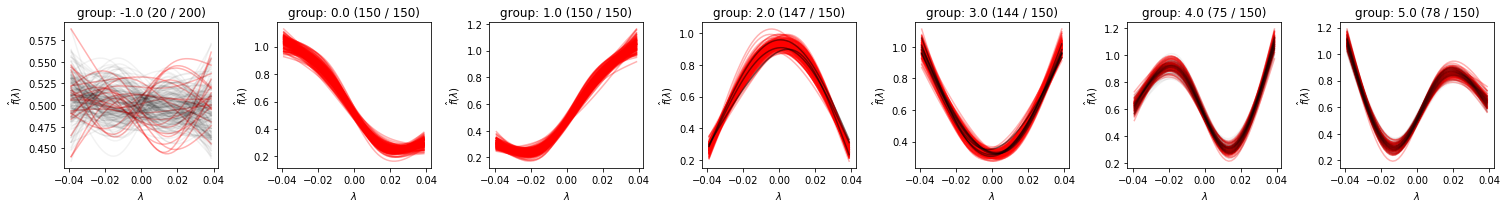

In [76]:
def plot_reject_group_curves(rej_idx, coeff_mtx, clust_labs, base_args, x_init, max_lines=200):
    x_vals, fit_mtx = refit_curves(coeff_mtx, base_args, x_init)
    assert coeff_mtx.shape[0] == len(clust_labs), "dimension mismatch"
    unique_labs = np.unique(clust_labs)

    # compute the fitted curves for all genes on the right space
    fig, axes = plt.subplots(1, len(unique_labs), figsize=(3*len(unique_labs),3))
    for i_ax, i_lab in enumerate(unique_labs):
        ax = axes[i_ax]
        # total selection
        sel_var_idx = [i for i, lab in enumerate(clust_labs) if lab == i_lab]
        # rejections
        sel_rej_idx = list(set(rej_idx).intersection(set(sel_var_idx)))
        # remaining
        sel_acc_idx = list(set(sel_var_idx).difference(set(rej_idx)))
        sel_acc_idx = sel_acc_idx[:min(max_lines-len(sel_rej_idx),len(sel_acc_idx))]
        rej_alpha = 0.3
        acc_alpha = 0.5
        if (len(sel_acc_idx) * 2  > len(sel_rej_idx)):
            acc_alpha = 0.05            
        plot_multi_curves(ax, x_vals, fit_mtx[:, sel_rej_idx], 
                          alpha=rej_alpha, color="red")
        plot_multi_curves(ax, x_vals, fit_mtx[:, sel_acc_idx], 
                          alpha=acc_alpha, color="black")
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(r"$\hat{f}(\lambda)$")
        ax.set_title(r"group: {} ({} / {})".format(i_lab, len(sel_rej_idx), 
                                                   len(sel_rej_idx) + len(sel_acc_idx)))
    plt.tight_layout()
    plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_curves.pdf")
    plt.show()
    
plot_reject_group_curves(rej_idx, c_mtx, var_ids, base_args, result["lam_update"])


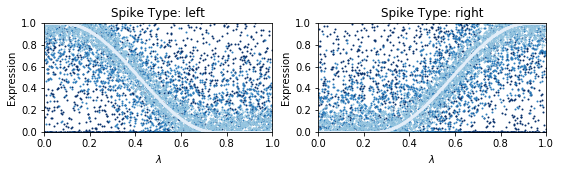

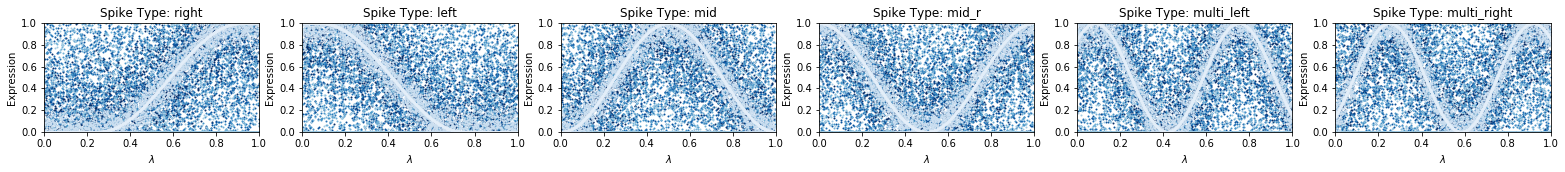

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 300, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


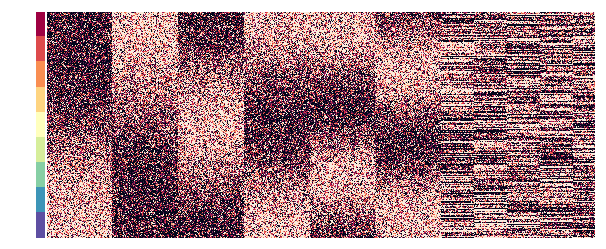

In [75]:
visualize_setup(sim_id, plot_mtx=True)